# TP FINAL Debandi

## Carga de datos y preparación del dataset

En este trabajo utilizo los datos de Covid-19 junto con un dataset complementario de información sobre cuando cada persona es migrante o no.

Este notebook levanta tres archivos: 
casosCovid: es un archivo de casos de marzo 2020 hasta mayo 2021. Este archivo fue bajado desde el sitio de datos abiertos del Ministerio de Salud de Argentina
http://datos.salud.gob.ar/dataset?groups=covid-19

migrantes2020 y migrantes2021: ambos archivos corresponden a dos pedidos de acceso a la información publica realizados en 2021. Este archivo contempla el ID-caso y algunos campos para dar cuenta de la nacionalidad y el país de nacimiento de cada persona.

La cantidad de registros del archivo de casos es dee 15.071.716 
Dado el volumen y el tiempo que llevaba este procesamiento de manera local, para este trabajo se realizó una muesta del 10%.


Esta notebook levanta los archivos de casos y toma una muestra del 10%., Hace un join con los datos de migrantes y se seleccionan las variables de interés.
Luego se guardan los datos en formato parquet. En la notebook de análisis se toman directamente estos datos.

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("pyspark-intro")
    .config("spark.driver.memory", "512m")
    .config("spark.driver.cores", "1")
    .config("spark.executor.memory", "512m")
    .config("spark.executor.cores", "1")
    .config("spark.sql.shuffle.partitions", "2")
    .getOrCreate()
)

# Levanto los datos y los exploro

Levanto el dataset de casos con los tipos de cada columna para poder trabajarlos

In [3]:
#especifico el esquema para poder definir los tipos
from pyspark.sql.types import *

schema = (StructType()
          .add("id_evento_caso", IntegerType())
          .add("sexo", StringType())
          .add("edad", IntegerType())
          .add("edad_años_meses", IntegerType())
          .add("residencia_pais_nombre", StringType())
          .add("residencia_provincia_nombre", StringType())
          .add("residencia_departamento_nombre", StringType())
          .add("carga_provincia_nombre", StringType())
          .add("fecha_inicio_sintomas", DateType())

          .add("fecha_apertura", DateType())
          .add("sepi_apertura", IntegerType())
          .add("fecha_internacion", DateType())
          .add("cuidado_intensivo", StringType())
          .add("fecha_cui_intensivo", DateType())
          .add("fallecido", StringType())
          .add("fecha_fallecimiento", DateType())
          
          .add("asistencia_respiratoria_mecanica", DateType())
          .add("carga_provincia_id", IntegerType())
          .add("origen_financiamiento", StringType())
          .add("clasificacion", StringType())
          .add("clasificacion_resumen", StringType())
          .add("residencia_provincia_id", DateType())
          .add("fecha_diagnostico", DateType())
          .add("residencia_departamento_id", IntegerType())
          .add("ultima_actualizacion", IntegerType())

         )

In [4]:
#levanto los casos
#dfcasos = spark.read.csv("/dataset/covid/Covid19Casos.csv", header=True)

dfcasosCompleto = spark.read.csv("/dataset/covid/Covid19Casos.csv", 
                        schema=schema, header=True)



In [5]:
##l .show muestra todo null. Luego la información está bien.
#dcasos.show()


In [6]:
#dfcasosCompleto.count()

Hay un total de 15.071.716 casos.

NOTA: el procesamiento está llevando muchisimo tiempo cada vez. Es un dataset muy grande por lo que voy a trabajar tomando solo el 10% de los casos para poder hacer el procesamiento. 

In [7]:
#Randomly sample 10% of the data without replacement
dfcasos = dfcasosCompleto.sample(False, 0.10, seed=7)

In [8]:
dfcasos.count()

1507618

Cantidad de casos: 1.507.101

In [9]:
dfcasos.printSchema()

root
 |-- id_evento_caso: integer (nullable = true)
 |-- sexo: string (nullable = true)
 |-- edad: integer (nullable = true)
 |-- edad_años_meses: integer (nullable = true)
 |-- residencia_pais_nombre: string (nullable = true)
 |-- residencia_provincia_nombre: string (nullable = true)
 |-- residencia_departamento_nombre: string (nullable = true)
 |-- carga_provincia_nombre: string (nullable = true)
 |-- fecha_inicio_sintomas: date (nullable = true)
 |-- fecha_apertura: date (nullable = true)
 |-- sepi_apertura: integer (nullable = true)
 |-- fecha_internacion: date (nullable = true)
 |-- cuidado_intensivo: string (nullable = true)
 |-- fecha_cui_intensivo: date (nullable = true)
 |-- fallecido: string (nullable = true)
 |-- fecha_fallecimiento: date (nullable = true)
 |-- asistencia_respiratoria_mecanica: date (nullable = true)
 |-- carga_provincia_id: integer (nullable = true)
 |-- origen_financiamiento: string (nullable = true)
 |-- clasificacion: string (nullable = true)
 |-- clasif

Analizo las columnas y sus valores.

In [10]:
#summary de las variables principales

#dfcasos.select("sexo", "edad","sepi_apertura").summary().show()

+-------+-------+-----------------+------------------+
|summary|   sexo|             edad|     sepi_apertura|
+-------+-------+-----------------+------------------+
|  count|1507618|          1507101|           1507618|
|   mean|   null|38.88564933604317|23.585339920324646|
| stddev|   null|17.97187743019407|13.858153122317686|
|    min|      F|              -14|                 1|
|    25%|   null|               26|                14|
|    50%|   null|               37|                22|
|    75%|   null|               50|                33|
|    max|     NR|              221|                53|
+-------+-------+-----------------+------------------+


In [11]:
#distribución de las variables categoriales: fallecido
#dfcasos.groupBy('fallecido').count().orderBy('count').show()

Dejo la distribución aqui para no tener que reprocesarlo la proxima
+---------+-------+
|fallecido|  count|
+---------+-------+
|       SI|  11949|
|       NO|1495669|
+---------+-------+

In [12]:
#distribución de la variable clasificación
#dfcasos.groupBy("clasificacion").count().show() 


+--------------------+------+
|       clasificacion| count|
+--------------------+------+
|Caso confirmado p...|386047|
|Caso con resultad...| 87962|
|Caso sospechoso -...| 21946|
|Caso sospechoso -...|  1249|
|Caso confirmado p...| 15161|
|Caso confirmado p...| 40754|
|Caso con resultad...|  1232|
|Caso confirmado p...|   652|
|    Otro diagnostico|   886|
|Caso sospechoso -...|   123|
|Caso sospechoso  ...|   483|
|Caso confirmado p...|   227|
|      Sin clasificar|    44|
|Caso confirmado p...| 10440|
|Caso sospechoso -...|    48|
|Caso sospechoso -...|     6|
|Caso sospechoso -...|  1632|
|     Caso Descartado|881287|
|Caso confirmado p...| 10723|
|Caso confirmado p...|  9999|
+--------------------+------+
only showing top 20 rows

In [13]:
#dfcasos.groupBy("clasificacion_resumen").count().show() 

+---------------------+------+
|clasificacion_resumen| count|
+---------------------+------+
|           Descartado|884392|
|           Sospechoso|148610|
|           Confirmado|474572|
|       Sin Clasificar|    44|
+---------------------+------+

In [14]:
#quiero analizar la cantidad de fallecidos por dia, de modo de ver la serie temporal.

#dftemp = dfcasos.groupBy("fecha_apertura","fallecido").count().sort("fecha_apertura") 
#dftemp.show(10)
dfcasos.createOrReplaceTempView("dfcasos")

dfTemp2= spark.sql("""
    Select fecha_apertura AS fecha, count(*) AS fallecidos
    FROM dfcasos
    Where fallecido='SI'
    GROUP BY fecha_apertura
    ORDER BY fecha_apertura asc
    """)
dfTemp2.show()

+----------+----------+
|     fecha|fallecidos|
+----------+----------+
|2020-03-12|         1|
|2020-03-17|         1|
|2020-03-19|         1|
|2020-03-20|         1|
|2020-03-21|         1|
|2020-03-23|         2|
|2020-03-24|         2|
|2020-03-25|         1|
|2020-03-26|         1|
|2020-03-27|         3|
|2020-03-28|         3|
|2020-03-30|         8|
|2020-03-31|         2|
|2020-04-01|         3|
|2020-04-02|         2|
|2020-04-03|         3|
|2020-04-04|         3|
|2020-04-05|         2|
|2020-04-06|         4|
|2020-04-07|         4|
+----------+----------+
only showing top 20 rows



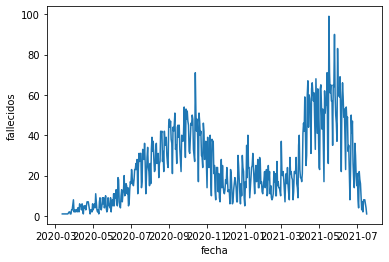

In [15]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
sns.lineplot(x="fecha", y="fallecidos", data=dfTemp2.toPandas())
plt.show()


# levanto el dataset de migrantes

Voy a levantar ahora los dos archivos de migrantes, unirlos. Estos archivos corresponden a dos pedidos de información distintos.

In [16]:
schema_mig = (StructType()
          .add("id_caso", IntegerType())
          .add("nacionalidad", StringType())
          .add("pais_nacimiento", StringType())
          .add("tipo_doc", StringType())
          .add("nro_doc", IntegerType())
          .add("doc_argentino", IntegerType())
          .add("base", IntegerType())
         )

In [17]:
#dfmig1 = spark.read.option("delimiter", ";").csv("/dataset/covid/migrantes2020.csv", header=True)


In [18]:
dfmig1 = (spark.read.option("delimiter", ";").csv("/dataset/covid/migrantes2020.csv", 
                         schema=schema_mig, header=True, 
                         ignoreLeadingWhiteSpace=True, 
                         ignoreTrailingWhiteSpace=True))


In [19]:
#dfmig1.show()

In [20]:
dfmig2 = (spark.read.option("delimiter", ";").csv("/dataset/covid/migrantes2021.csv", 
                         schema=schema_mig, header=True, 
                         ignoreLeadingWhiteSpace=True, 
                         ignoreTrailingWhiteSpace=True))

In [21]:
dfmig2.printSchema()

root
 |-- id_caso: integer (nullable = true)
 |-- nacionalidad: string (nullable = true)
 |-- pais_nacimiento: string (nullable = true)
 |-- tipo_doc: string (nullable = true)
 |-- nro_doc: integer (nullable = true)
 |-- doc_argentino: integer (nullable = true)
 |-- base: integer (nullable = true)



In [22]:
dfmig= dfmig1.union(dfmig2)

# To remove the duplicates:

#result = result.dropDuplicates()


In [23]:
dfmig.printSchema()

root
 |-- id_caso: integer (nullable = true)
 |-- nacionalidad: string (nullable = true)
 |-- pais_nacimiento: string (nullable = true)
 |-- tipo_doc: string (nullable = true)
 |-- nro_doc: integer (nullable = true)
 |-- doc_argentino: integer (nullable = true)
 |-- base: integer (nullable = true)



In [24]:
dfmig.count()

11437754

In [25]:
#dfmig.count()
#vuelvo a chequear la distribución de fallecido
dfmig.groupBy('pais_nacimiento').count().orderBy('count').show()

+-------------------+-----+
|    pais_nacimiento|count|
+-------------------+-----+
|       Islas Caiman|    1|
|            Bahamas|    1|
|Antillas Holandesas|    1|
|       Azerbaidahan|    1|
|            Grenada|    1|
|              Malta|    1|
|           Barbados|    1|
| Bosnia Herzegovina|    1|
|            Jamaica|    1|
|               Mal�|    1|
|             Gambia|    1|
|             Zambia|    1|
|              Qatar|    1|
|    Costa de Marfil|    1|
|            Eritrea|    1|
|          Sri Lanka|    1|
|     Timor Oriental|    1|
|           Suriname|    1|
|              Gab�n|    1|
|   French Polynesia|    1|
+-------------------+-----+
only showing top 20 rows



## Cración de base casos + migrantes

Creo una unica base haciendo join con ambas bases: casos y migrantes. Me quedo además solo con las columnas que me interesan.

BASE CASOS:
sexo
edad: tomo solo este campo y no el de meses que corresponde a niños menores de 1 año. SOn pocos casos y puede confundir.

Me quedo con estas tres fechas:
fecha_apertura: fecha en que se inicia el registro del caso
fecha_inicio_sintomas: fecha en que se inician los síntomas
fecha_diagnostico: fecha en que se lo diagnostica
sepi_apertura: este campo enumera la semana epidemilógica
origen_financiamiento: público privado
clasificacion_resumen: me quedo solo con esta columna simplificada de clasificación. Permitirá luego filtrar solo aquellos casos confirmados.

Sobre los campos de residencia conservo solo aquellos que tienen el id
residencia_provincia_id 
residencia_departamento_id

Estos tres campos están directamente relacionados con aquellos que se internaro o fallecieron, se toman para el análisis inicial
fecha_internacion,cuidado_intensivo,fallecido

BASE MIGRANTES
me quedo solo con pais de nacimiento

NOTA: para un trabajo más específico hay que diferenciar entre migrantes y extranjeros. Para definir migrantes se puede tomar personas nacidas en un país distinto a Argentina pero que residen en Argentina. (https://www.academia.edu/44535050/Incidencia_del_COVID_en_la_poblaci%C3%B3n_migrante_en_Argentina)
En este trabajo se tomará directamente pais de nacimiento <> Argentina.

In [30]:
##
dfcasos.createOrReplaceTempView("dfcasos")
dfmig.createOrReplaceTempView("dfmig")

dfTemp2= spark.sql(""" SELECT id_evento_caso,sexo, edad,
fecha_inicio_sintomas,fecha_apertura,fecha_diagnostico,
sepi_apertura,origen_financiamiento,
residencia_provincia_id,residencia_departamento_id,
pais_nacimiento,
fecha_internacion,cuidado_intensivo,fallecido
    FROM dfcasos join dfmig on dfcasos.id_evento_caso=dfmig.id_caso
    where clasificacion_resumen='Confirmado'
    """)



In [31]:
dfTemp2.count()

166515

El join de ambas bases (casos y migrantes) filtrado por confirmado se obtienen 166.515 casos

In [32]:
#vuelvo a chequear la distribución de fallecido
dfTemp2.groupBy('fallecido').count().orderBy('count').show()

+---------+------+
|fallecido| count|
+---------+------+
|       SI|  4867|
|       NO|161648|
+---------+------+



In [33]:
#vuelvo a chequear la distribución de fallecido
#dfTemp2.groupBy('pais_nacimiento').count().orderBy('count').show()

+--------------------+-----+
|     pais_nacimiento|count|
+--------------------+-----+
|           Marruecos|    1|
|           Eslovenia|    1|
|           Antartida|    1|
|           Tailandia|    1|
|           Sud�frica|    1|
|           Dinamarca|    1|
|           Kazajst�n|    1|
|              Egipto|    1|
|           Palestina|    1|
|     Rep�blica Checa|    1|
|           Filipinas|    1|
|             Austria|    1|
|              Rwanda|    1|
|              Taiw�n|    1|
|             Andorra|    1|
|                Ir�n|    1|
|               Gab�n|    1|
|              L�bano|    1|
|             Rumania|    1|
|British Indian Oc...|    1|
+--------------------+-----+
only showing top 20 rows



Se guardan los archivos en formato parquet. Voy a probar si luego se mejora el performance.

In [34]:
dfTemp2.write.parquet("/dataset/parquet-confirmados-muestra/covid-muestra.parquet") 